In [1]:
import time

import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import xgboost as xgb
import torch

from gbnet import lgbmodule, xgbmodule

# 01. Basic regression example comparing GBNet and XGBoost

In [4]:
# Generate Dataset
np.random.seed(100)
n = 1000
input_dim = 20
output_dim = 1
X = np.random.random([n, input_dim])
B = np.random.random([input_dim, output_dim])
Y = X.dot(B) + np.random.random([n, output_dim])

iters = 100

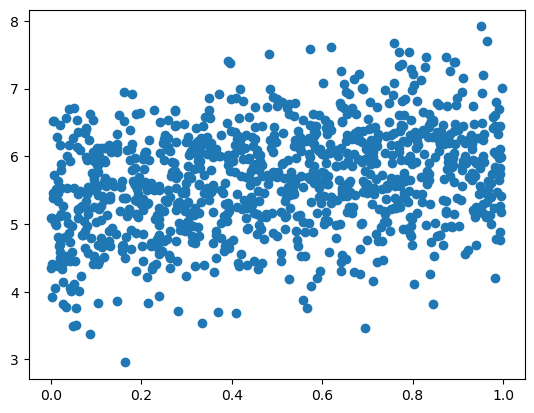

In [5]:
plt.scatter(X[:,0], Y)

In [19]:
# XGBoost training for comparison

t0 = time.time()

xbst = xgb.train(
    params={'objective': 'reg:squarederror', 'base_score': 0.0},
    dtrain=xgb.DMatrix(X, label=Y),
    num_boost_round=iters
)
t1 = time.time()
print(t1 - t0)

0.04389190673828125


In [54]:
# XGBModule training

t0 = time.time()

# define XGBModule component
xnet = lgbmodule.LGBModule(n, input_dim, output_dim)

# define loss
xmse = torch.nn.MSELoss()

# Fit
losses = []
for i in range(iters):
    xnet.zero_grad()
    xpred = xnet(X)

    loss = 1/2 * xmse(xpred, torch.Tensor(Y)) # xgboost uses 1/2 (Y - P)^2
    loss.backward(create_graph=True)  # NOTE create_graph is needed so that gradients/hessians can be calculated in GBNet code
    losses.append(loss.item())

    xnet.gb_step()
xnet.eval()  # like any torch module, use eval mode for predictions

t1 = time.time()
print(t1 - t0)

0.04227614402770996


In [55]:
xgb_preds = xbst.predict(xgb.DMatrix(X))
gbnet_preds = xnet(X).detach().numpy().flatten()

print(np.max(np.abs(xgb_preds - gbnet_preds))) 

0.2436943


Text(0, 0.5, 'GBNet Predictions')

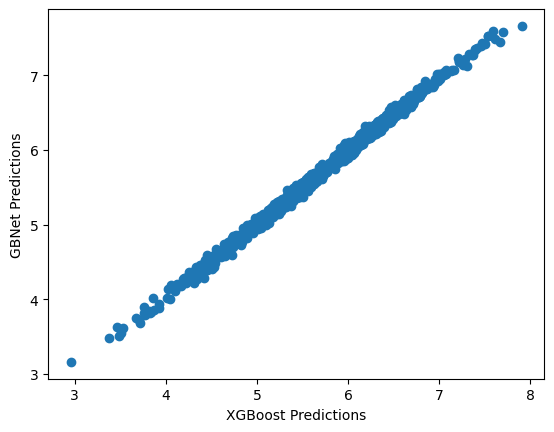

In [56]:
plt.scatter(xgb_preds, gbnet_preds)
plt.xlabel("XGBoost Predictions")
plt.ylabel("GBNet Predictions")

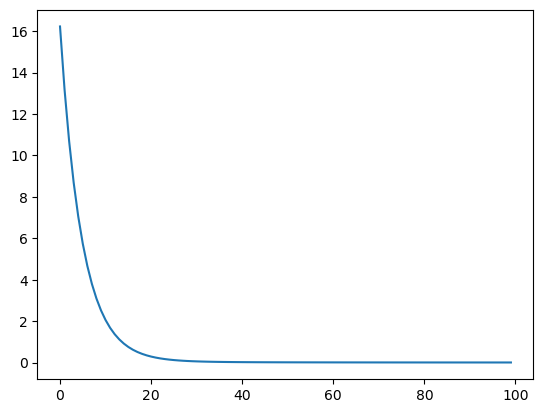

In [57]:
plt.plot(losses)

# 02. Matrix Factorization

## Overview

Can we factorize a matrix, $M$ such that elements of $M$ are the inner product of a row embedding and a column embedding? For example, recommendation systems might use "user" vectors and "item" vectors to build a recommendation system.

$$ M_{i, j} = \mbox{GBDT}_{\mbox{rows}}(i) \mbox{GBDT}_{\mbox{columns}}(j)^T $$


In [59]:
import pandas as pd
import torch
import xgboost as xgb

from gbnet.xgbmodule import XGBModule


class Factor(torch.nn.Module):
    def __init__(self, nrows, ncols, params={}):
        super(Factor, self).__init__()
        self.rowv = XGBModule(nrows, 1, min(ncols, nrows), params=params.copy())
        self.colv = XGBModule(ncols, 1, min(ncols, nrows), params=params.copy())

        self.row_dmat = xgb.DMatrix(
            pd.Series(range(nrows), dtype='category').to_frame(),
            enable_categorical=True
        )
        self.col_dmat = xgb.DMatrix(
            pd.Series(range(ncols), dtype='category').to_frame(),
            enable_categorical=True
        )

    def forward(self):
        row_vecs = self.rowv(self.row_dmat) + 1
        col_vecs = self.colv(self.col_dmat) + 1

        return torch.matmul(row_vecs, col_vecs.transpose(0,1))

    def gb_step(self):
        self.rowv.gb_step()
        self.colv.gb_step()
        


import numpy as np

nrows = 5
ncols = 6
np.random.seed(10110)
M = torch.Tensor(np.random.random([nrows, ncols]))

FM = Factor(nrows, ncols, params={
    'min_child_weight': 0,
    'subsample': 0.7
})
loss_fn = torch.nn.MSELoss()

losses = []
for i in range(500):
    FM.zero_grad()
    rc = FM()
    loss = loss_fn(rc.flatten(), M.flatten())
    losses.append(loss.item())

    loss.backward(create_graph=True)
    FM.gb_step()
    




2.364652118558297e-06


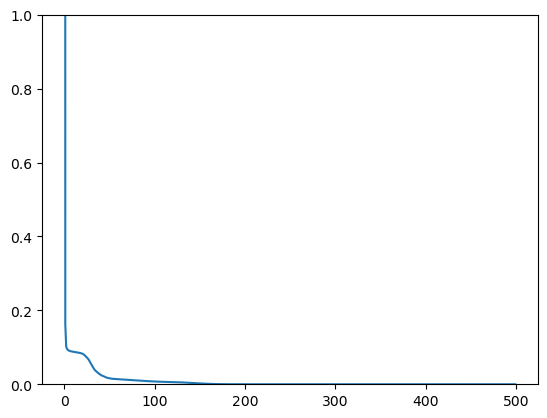

In [63]:
from matplotlib import pyplot as plt
plt.plot(losses)
print(min(losses))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([0,1]);

In [64]:
M

tensor([[0.8903, 0.8419, 0.1306, 0.3951, 0.0301, 0.8619],
        [0.8536, 0.0387, 0.2257, 0.2717, 0.2321, 0.7835],
        [0.4792, 0.1685, 0.0128, 0.8537, 0.7494, 0.3868],
        [0.1672, 0.7412, 0.6952, 0.9978, 0.5096, 0.7290],
        [0.1811, 0.3709, 0.6652, 0.5594, 0.9971, 0.0343]])

In [65]:
rc

tensor([[0.8905, 0.8411, 0.1318, 0.3956, 0.0288, 0.8623],
        [0.8529, 0.0418, 0.2212, 0.2707, 0.2336, 0.7831],
        [0.4796, 0.1650, 0.0174, 0.8542, 0.7491, 0.3872],
        [0.1670, 0.7409, 0.6948, 0.9975, 0.5102, 0.7290],
        [0.1811, 0.3709, 0.6649, 0.5595, 0.9971, 0.0344]],
       grad_fn=<MmBackward0>)

# 03. Ordinal Regression Example

## Brief overview:

F(X) produces a single number that gets thresholded at multiple points to produce predicted classes. This ensures, for example, class 4 is "higher" than classes 2 and 3. Standard classification doesn't have this ordering.

## Loss function

Minimize negative log-likelihood derived from

$$ P(Y \leq i) = \sigma(\theta_i - F(X))$$

where $\theta_i$ are "breakpoints" requiring estimation.

Overall the ordinal regression loss is (1) complex due to modeling cumulative probabilities and (2) the $\theta_i$ parameters are part of the loss function and should be optimized themselves.  GBNet estimates $\theta_i$ in the standard way with PyTorch (ie optimized via gradient descent methods).

In [66]:
import pandas as pd
from gbnet.models import ordinal_regression

# Load and split data
url = f"https://raw.githubusercontent.com/gagolews/ordinal-regression-data/refs/heads/master/ailerons.csv"

df = pd.read_csv(url)
train = df.sample(int(df.shape[0] * 0.7), random_state=10110).reset_index(drop=True).copy()
test = df[~df.index.isin(train.index)].reset_index(drop=True).copy()
    
xcols = [col for col in df.columns if not (col == 'response')]
ycol = 'response'

num_classes = df[ycol].nunique()

# Initialize and fit ordinal regression model
ordboost = ordinal_regression.GBOrd(num_classes)
ordboost.fit(train[xcols], train[ycol])
    
test['pred'] = ordboost.predict(test[xcols], return_logits=False)

# extract breakpoints from the underlying loss function
loss_fn = ordboost.loss_fn
xgrid = np.linspace(-15, 15, 200)
bp = loss_fn.breakpoints.detach().numpy()

# get class probabilities over a grid of F(X) values
probs = loss_fn.get_pred_probs(torch.Tensor(xgrid).reshape([-1,1])).detach().numpy()

Text(12.5, 1, '8')

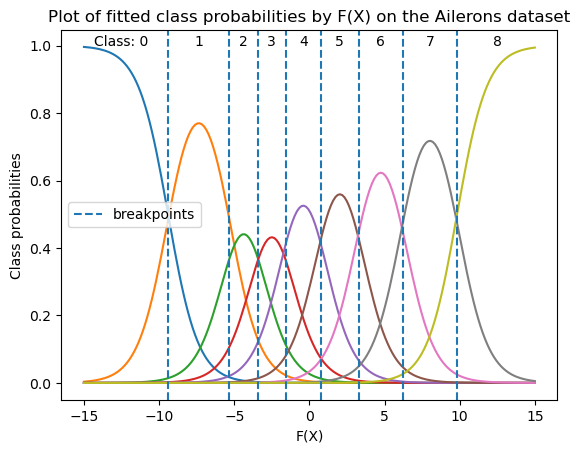

In [67]:
from matplotlib import pyplot as plt


plt.plot(xgrid, probs[:,0])
plt.plot(xgrid, probs[:,1])
plt.plot(xgrid, probs[:,2])
plt.plot(xgrid, probs[:,3])
plt.plot(xgrid, probs[:,4])
plt.plot(xgrid, probs[:,5])
plt.plot(xgrid, probs[:,6])
plt.plot(xgrid, probs[:,7])
plt.plot(xgrid, probs[:,8])
#plt.plot(xgrid, probs[:,3])

plt.xlabel('F(X)')
plt.ylabel('Class probabilities')

for b in bp:
    if b == bp[0]:
        plt.axvline(b, linestyle='--', label='breakpoints')
    else:
        plt.axvline(b, linestyle='--')
plt.legend(loc='center left')
plt.title('Plot of fitted class probabilities by F(X) on the Ailerons dataset')

plt.text(-12.5, 1, 'Class: 0', ha='center')
index = 1
for midpoint in ((bp[1:] + bp[:-1]) / 2):
    plt.text(midpoint, 1, str(index), ha='center')
    index = index + 1

plt.text(12.5, 1, '8', ha='center')

In [68]:
(df['response']-1).value_counts()

response
6    1030
1     964
7     933
0     872
5     863
4     758
8     647
3     575
2     512
Name: count, dtype: int64

# 04. Mixture of Experts (MoE) / data-aware model averaging in comparison to bayesian methods for mean estimation

A version of MoE looks like the following.  Multiple models are combined via weights where the weights themselves are determined by a model. Can we use XGBoost to determine those weights?

$$\begin{eqnarray}
\mbox{Prediction}(X) &=& w_1 \mbox{Model}_1(X) + w_2 \mbox{Model}_2(X) + ... \\
&s.t.&
\sum_i w_i = 1 \\
& \& & w_i = \mbox{link}(\mbox{XGBoost}(X))_{[i]}
\end{eqnarray}
$$

A familiar version of this is bayesian mean estimation with a gaussian likelihood and using a conjugate prior. Final predictions are a convex combination of the prior mean, $\mu_0$ and the empirical average $\bar{x}$.

$$ \hat{\mu} = \mu_0 \frac{1}{1 + rn} + \bar{x} \frac{rn}{1 + rn} $$

where $r$ is the ratio of standard deviations (prior standard deviation over data standard deviation) and $n$ is the number of observations.

If GBNet can properly estimate a MoE, we should be able to estimate the optimal weights empirically using XGBoost/LightGBM.

In [76]:
import numpy as np
import pandas as pd


def get_row(seed=None):
    if seed is not None:
        np.random.seed(seed)

    N = np.random.randint(1, 101)
    MU = np.random.standard_cauchy()

    MU2 = np.random.normal(MU, 10)
    observations = np.random.normal(MU2, 10, N)

    return {
        'n': N,
        'xbar': np.mean(observations),
        'prior': MU,
        'truth': MU2
    }

def get_dataset(n, seed=None):
    if seed is not None:
        np.random.seed(seed)

    rows = []
    for i in range(n):
        rows.append(get_row())
    return pd.DataFrame(rows)

df = get_dataset(100_000, 101010)

df.head()        

,n,xbar,prior,truth
0,63,-3.620502,2.045308,-5.187889
1,47,-4.324446,0.349231,-2.075606
2,62,-1.650020,0.396121,-0.680244
3,77,-5.169910,-2.357304,-5.304541
4,30,8.379222,-3.276135,6.591356


In [77]:
from gbnet.xgbmodule import XGBModule
import torch

class MOE(torch.nn.Module):
    def __init__(self, n, params={}):
        super(MOE, self).__init__()
        self.logit_of_mix_prob = XGBModule(n, 1, 1, params=params)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, df):
        n = np.array(df['n']).reshape([-1,1])
        prior = torch.Tensor(np.array(df['prior'])).reshape([-1,1])
        xbar = torch.Tensor(np.array(df['xbar'])).reshape([-1,1])
        
        logit = self.logit_of_mix_prob(n)
        prob = self.sigmoid(logit)

        pred = prob * prior + (1 - prob) * xbar
        return pred, prob

    def gb_step(self):
        self.logit_of_mix_prob.gb_step()



In [78]:
moe = MOE(df.shape[0], params={
    'monotone_constraints': (-1,)
})


losses = []
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(moe.parameters())

losses = []
for i in range(100):
    optimizer.zero_grad()
    pred, prob = moe(df)

    loss = loss_fn(pred.flatten(), torch.Tensor(df['truth']).flatten())
    loss.backward(create_graph=True)  # create_graph=True required for any gbnet
    losses.append(loss.detach().numpy().copy())

    moe.gb_step()  # required to update the gbms

df['pred'] = pred.detach().numpy()
df['prob'] = prob.detach().numpy()

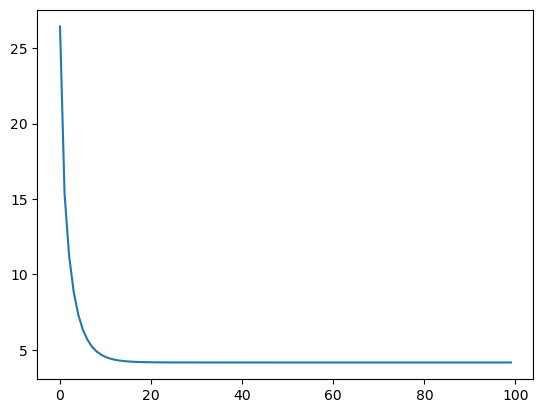

In [79]:
from matplotlib import pyplot as plt

plt.plot(losses)

In [80]:
from matplotlib import pyplot as plt

df['theoretical_prob'] = 1 / (1 + df['n'])
df['theoretical_pred'] = df['prior'] * df['theoretical_prob'] + df['xbar'] * (1 - df['theoretical_prob'])


print(((df['truth'] - df['pred'])**2).mean())
print(((df['truth'] - df['theoretical_pred'])**2).mean())

4.164446273514463
4.167060752202047


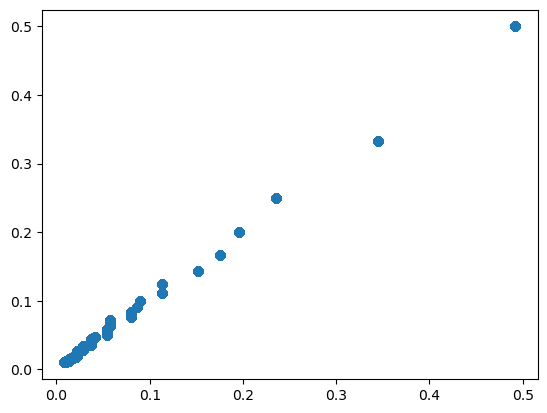

In [81]:
from matplotlib import pyplot as plt

plt.scatter(df['prob'], df['theoretical_prob'])

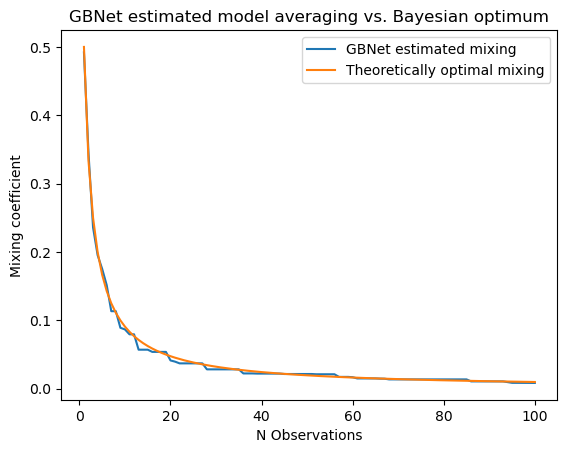

In [82]:
from matplotlib import pyplot as plt

tmp = df.sort_values('n').reset_index(drop=True).copy()


plt.plot(tmp['n'], tmp['prob'], label='GBNet estimated mixing')
plt.plot(tmp['n'], tmp['theoretical_prob'], label='Theoretically optimal mixing')
plt.xlabel("N Observations")
plt.ylabel("Mixing coefficient")
plt.title("GBNet estimated model averaging vs. Bayesian optimum")
plt.legend()

# 04. Forecasting using GBLinear for a trend

Text(0.5, 1.0, 'Prophet dataset: example_air_passengers.csv')

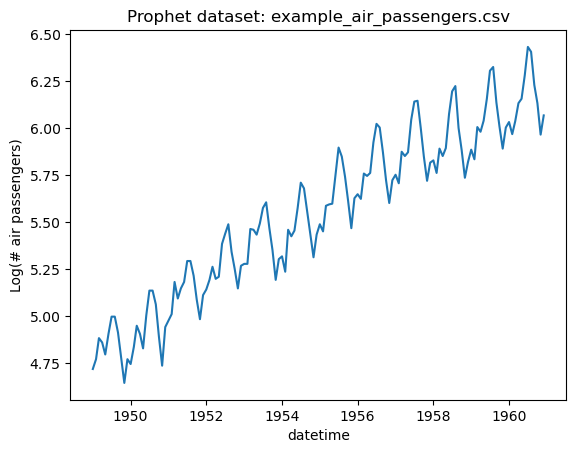

In [83]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

url = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv"

dataset = {
    'name': url.split('/')[-1],
    'data': pd.read_csv(url),
    'url': url,
    'ycol': 'y'
}

df = dataset['data']

plt.plot(pd.to_datetime(df['ds']), np.log(df['y']))
plt.xlabel('datetime')
plt.ylabel('Log(# air passengers)')
plt.title('Prophet dataset: example_air_passengers.csv')


In [84]:
import numpy as np
import pandas as pd
import torch

from gbnet.xgbmodule import XGBModule


class BasicForecast(torch.nn.Module):
    def __init__(self, n):
        super(BasicForecast, self).__init__()
        self.season = XGBModule(n, 1, 1)
        self.bn = torch.nn.LazyBatchNorm1d()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, pd_datetime_col):
        # Convert to usable components
        numeric_years = np.array(
            pd.to_numeric(pd_datetime_col).to_frame()
            / (365.25 * 24 * 60 * 60 * 1_000_000_000)
        )
        month = pd_datetime_col.dt.month

        # result = linear + season
        season = self.season(month.to_frame())
        linear = self.linear(self.bn(torch.Tensor(numeric_years)))
        return linear + season

    def gb_step(self):
        self.season.gb_step()
        

In [85]:
import numpy as np
import pandas as pd
import torch

from gbnet.xgbmodule import XGBModule
from gbnet.gblinear import GBLinear


class BasicForecastGBLinear(torch.nn.Module):
    def __init__(self, n):
        """ 2 components: trend, seasonality
        """
        super(BasicForecastGBLinear, self).__init__()
        self.season = XGBModule(n, 1, 1)
        self.linear = GBLinear(1, 1)

    def forward(self, pd_datetime_col):
        # Convert to usable components
        numeric_years = np.array(
            pd.to_numeric(pd_datetime_col).to_frame()
            / (365.25 * 24 * 60 * 60 * 1_000_000_000)
        )
        month = pd_datetime_col.dt.month

        # result = linear + season
        season = self.season(month.to_frame())
        linear = self.linear(numeric_years)
        return linear + season

    def gb_step(self):
        self.season.gb_step()
        self.linear.gb_step()
        

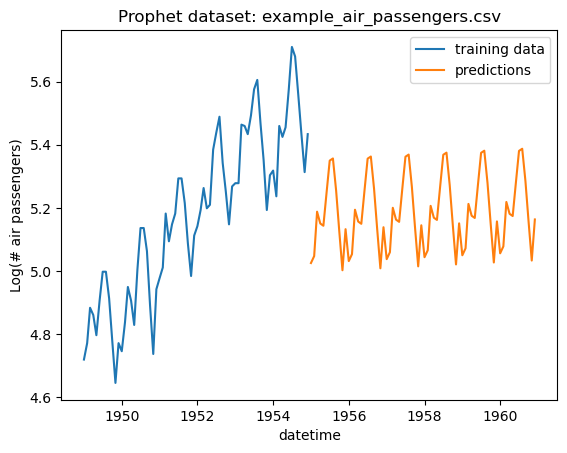

In [86]:
import time


X = df[['ds', 'y']].copy()
X['y'] = np.log(X['y'])
X['ds'] = pd.to_datetime(df['ds'])
X = X.sort_values('ds').reset_index(drop=True)
trainX = X.iloc[:round(X.shape[0]/2),].copy()
testX = X.iloc[round(X.shape[0]/2):,].reset_index(drop=True).copy()

bf = BasicForecast(trainX.shape[0])
optimizer = torch.optim.Adam(bf.parameters(), lr=0.1)

mse = torch.nn.MSELoss()

t0 = time.time()
losses = []
for i in range(20):
    optimizer.zero_grad()
    preds = bf(trainX['ds'])

    loss = mse(preds, torch.Tensor(np.array(trainX[['y']])))
    loss.backward(create_graph=True)  # create_graph=True required for any gbnet
    losses.append(loss.detach().numpy().copy())

    bf.gb_step()  # required to update the gbms
    optimizer.step()

bf.eval()

trainX['pred'] = bf(trainX['ds']).detach().numpy().flatten()
testX['pred'] = bf(testX['ds']).detach().numpy().flatten()

plt.plot(trainX['ds'], trainX['y'], label='training data')
plt.plot(testX['ds'], testX['pred'], label='predictions')

plt.xlabel('datetime')
plt.ylabel('Log(# air passengers)')
plt.title('Prophet dataset: example_air_passengers.csv')
plt.legend();

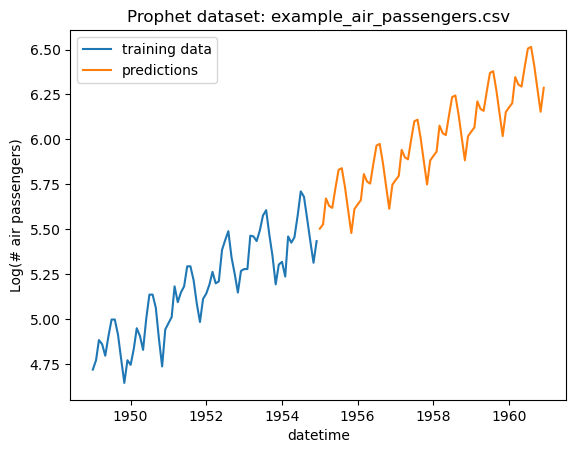

In [87]:
import time


X = df[['ds', 'y']].copy()
X['y'] = np.log(X['y'])
X['ds'] = pd.to_datetime(df['ds'])
X = X.sort_values('ds').reset_index(drop=True)
trainX = X.iloc[:round(X.shape[0]/2),].copy()
testX = X.iloc[round(X.shape[0]/2):,].reset_index(drop=True).copy()

bf = BasicForecastGBLinear(trainX.shape[0])
optimizer = torch.optim.Adam(bf.parameters(), lr=0.1)

mse = torch.nn.MSELoss()

t0 = time.time()
losses = []
for i in range(20):
    optimizer.zero_grad()
    preds = bf(trainX['ds'])

    loss = mse(preds, torch.Tensor(np.array(trainX[['y']])))
    loss.backward(create_graph=True)  # create_graph=True required for any gbnet
    losses.append(loss.detach().numpy().copy())

    bf.gb_step()  # required to update the gbms
    optimizer.step()

bf.eval()

trainX['pred'] = bf(trainX['ds']).detach().numpy().flatten()
testX['pred'] = bf(testX['ds']).detach().numpy().flatten()

plt.plot(trainX['ds'], trainX['y'], label='training data')
plt.plot(testX['ds'], testX['pred'], label='predictions')

plt.xlabel('datetime')
plt.ylabel('Log(# air passengers)')
plt.title('Prophet dataset: example_air_passengers.csv')
plt.legend();